# Анализ токсичности постов и комментариев из тематических сообществ ВК, посвященных ханты

## Сбор данных

In [1]:
import pandas as pd
import numpy as np
import re
from glob import glob

In [2]:
from nltk.stem.snowball import SnowballStemmer 
from nltk.corpus import stopwords
stop_words = stopwords.words('russian')

In [3]:
#Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess

In [4]:
import spacy

In [5]:
from sklearn.metrics import f1_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

In [6]:
import lightgbm as lgb
from lightgbm import LGBMClassifier

In [7]:
from catboost import CatBoostClassifier

In [8]:
import catboost as cb

In [9]:
from sklearn.model_selection import train_test_split, GridSearchCV

In [100]:
import matplotlib.pyplot as plt

In [114]:
import nltk
from nltk.probability import FreqDist
from nltk import word_tokenize

In [117]:
from wordcloud import WordCloud

In [10]:
nlp = spacy.load("ru_core_news_sm") #для лемматизации

In [11]:
stock_files = sorted(glob('C:/Users/Анастасия/programming python/proj_tonality_analysis/Посты_со_стены_сообщества_ханты/*.xlsx'))
df = pd.concat((pd.read_excel(file) for file in stock_files))

In [12]:
df.head()

,from_id,owner_id,domain,date,text,copy_text,copy_date,likes_count,comments_count,reposts,views,likers,comments,commentators
0,-143613888,-143613888,https://vk.com/feed?w=wall-143613888_1924,2022-10-09 19:29:19,"Слушай, а путешествие в любое время это кайф, ...",NaN,NaN,343,28,3,13495,"621359868,325639610,379875151,334467312,514734...","👏👏👏👍 | Истинна | Красавчик, да ещё и мудрый......","710391641,466352023,19022970,687064715,2514236..."
1,-143613888,-143613888,https://vk.com/feed?w=wall-143613888_1909,2022-09-28 14:34:55,"Понеслось, сезон скоро открыт будет зимний",NaN,NaN,158,13,5,5193,"467327440,135987902,33102955,328362141,5376617...","Печально .жаль что это не Украина | Красиво, н...","442659428,710391641,151188104"
2,-143613888,-143613888,https://vk.com/feed?w=wall-143613888_1876,2022-09-16 17:57:23,Порыбачим ? Спорим один бросок сделаю и поймаю,NaN,NaN,356,30,10,9726,"311648292,650382140,413499352,259464683,120684...","👍👍👍 | Красавчик | Хант, ты лучший... | 👏👏👏 | А...","499109777,287553799,19022970,267355788,5301492..."
3,-143613888,-143613888,https://vk.com/feed?w=wall-143613888_1864,2022-09-14 17:51:19,Вот и добыча рыбы традиционными способами,NaN,NaN,203,5,9,9018,"156622455,391833224,171789204,406213996,380279...",Круто | 👍 | Катец👍 | Акробаты😂 | Вот наш тради...,"3220809,427988557,126309604,509760771,554615861"
4,-143613888,-143613888,https://vk.com/feed?w=wall-143613888_1862,2022-09-14 17:37:18,"Привет, подготовка к зиме уже началась, достат...",NaN,NaN,213,0,2,4313,"391833224,406213996,562663376,17147673,885019,...",NaN,NaN


## Предобработка и добавление новых признаков

Нас интересует текстовая информация. В данном датасете это колонки text, copy_text и comments.

Просмотрим общую информацию о датасете:

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1600 entries, 0 to 99
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   from_id         1600 non-null   int64 
 1   owner_id        1600 non-null   int64 
 2   domain          1600 non-null   object
 3   date            1600 non-null   object
 4   text            782 non-null    object
 5   copy_text       749 non-null    object
 6   copy_date       794 non-null    object
 7   likes_count     1600 non-null   int64 
 8   comments_count  1600 non-null   int64 
 9   reposts         1600 non-null   int64 
 10  views           1600 non-null   int64 
 11  likers          1186 non-null   object
 12  comments        311 non-null    object
 13  commentators    311 non-null    object
dtypes: int64(6), object(8)
memory usage: 187.5+ KB


Видим, что в интересующих колонках есть пропуски в данных. Заменим их на пустые строки:

In [14]:
df.text = df.text.fillna('')
df.copy_text = df.copy_text.fillna('')
df.comments = df.comments.fillna('')

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1600 entries, 0 to 99
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   from_id         1600 non-null   int64 
 1   owner_id        1600 non-null   int64 
 2   domain          1600 non-null   object
 3   date            1600 non-null   object
 4   text            1600 non-null   object
 5   copy_text       1600 non-null   object
 6   copy_date       794 non-null    object
 7   likes_count     1600 non-null   int64 
 8   comments_count  1600 non-null   int64 
 9   reposts         1600 non-null   int64 
 10  views           1600 non-null   int64 
 11  likers          1186 non-null   object
 12  comments        1600 non-null   object
 13  commentators    311 non-null    object
dtypes: int64(6), object(8)
memory usage: 187.5+ KB


Удалим все ссылки из данных:

In [16]:
def remove_urls(text):
    return [re.sub(r'http\S+', '', sent) for sent in text]

In [17]:
for column in (['text', 'copy_text', 'comments']):
    df[column] = remove_urls(df[column])

In [18]:
df.head(10)

,from_id,owner_id,domain,date,text,copy_text,copy_date,likes_count,comments_count,reposts,views,likers,comments,commentators
0,-143613888,-143613888,https://vk.com/feed?w=wall-143613888_1924,2022-10-09 19:29:19,"Слушай, а путешествие в любое время это кайф, ...",,NaN,343,28,3,13495,"621359868,325639610,379875151,334467312,514734...","👏👏👏👍 | Истинна | Красавчик, да ещё и мудрый......","710391641,466352023,19022970,687064715,2514236..."
1,-143613888,-143613888,https://vk.com/feed?w=wall-143613888_1909,2022-09-28 14:34:55,"Понеслось, сезон скоро открыт будет зимний",,NaN,158,13,5,5193,"467327440,135987902,33102955,328362141,5376617...","Печально .жаль что это не Украина | Красиво, н...","442659428,710391641,151188104"
2,-143613888,-143613888,https://vk.com/feed?w=wall-143613888_1876,2022-09-16 17:57:23,Порыбачим ? Спорим один бросок сделаю и поймаю,,NaN,356,30,10,9726,"311648292,650382140,413499352,259464683,120684...","👍👍👍 | Красавчик | Хант, ты лучший... | 👏👏👏 | А...","499109777,287553799,19022970,267355788,5301492..."
3,-143613888,-143613888,https://vk.com/feed?w=wall-143613888_1864,2022-09-14 17:51:19,Вот и добыча рыбы традиционными способами,,NaN,203,5,9,9018,"156622455,391833224,171789204,406213996,380279...",Круто | 👍 | Катец👍 | Акробаты😂 | Вот наш тради...,"3220809,427988557,126309604,509760771,554615861"
4,-143613888,-143613888,https://vk.com/feed?w=wall-143613888_1862,2022-09-14 17:37:18,"Привет, подготовка к зиме уже началась, достат...",,NaN,213,0,2,4313,"391833224,406213996,562663376,17147673,885019,...",,NaN
5,-143613888,-143613888,https://vk.com/feed?w=wall-143613888_1831,2022-09-09 15:55:46,Добыча рыбы способом как учили нас наши предки...,,NaN,244,9,18,5675,"156622455,20591207,406213996,174467000,322590,...",Мы из катонки делаем | К этой системе нужен ещ...,"458593958,139030175,429773926,427988557,283951..."
6,-143613888,-143613888,https://vk.com/feed?w=wall-143613888_1821,2022-09-09 12:34:35,,,NaN,258,32,15,13556,"156622455,413499352,406213996,2266017,2279629,...",😂👍 | 😄 | 🤣🤣🤣 | Приколисты)))) | 🤣🤣🤣🤣 зачёт | Р...,"514734662,213823111,633746918,417607469,499109..."
7,-143613888,-143613888,https://vk.com/feed?w=wall-143613888_1774,2022-09-08 13:08:31,Пообедали в ресторане Вонтко самое натуральное...,,NaN,225,45,6,4284,"391833224,406213996,172264,1268703,1768026,309...","Не ешь с ножа___злым будешь...🤣🤣🤣🤔 | Да, да, у...","507140397,512252499,237901553,488259866,442659..."
8,-143613888,-143613888,https://vk.com/feed?w=wall-143613888_1767,2022-09-07 15:25:30,,🌲 р. Тром-Аган в переводе «Божья река» ✅ Река...,2022-09-07 11:35:36,113,1,2,2588,"311648292,2266017,3128998,3482563,6889129,9097...","Хорошая река, много хороших моментов с ней свя...",201418567
9,-143613888,-143613888,https://vk.com/feed?w=wall-143613888_1748,2022-09-05 05:12:06,"Очередная осень подкралась, совсем скоро наши ...",,NaN,627,20,6,19924,"27730851,571142602,171789204,172264,622582,103...",🤗 зима не за горами.... | 😍😍😍🤗🤗🤗👍👍👍❤❤❤ | Класс...,"507140397,418995306,678451445,65762316,2650538..."


Теперь можем изменять текстовые колонки. Сделаем токенизацию и очистку текста от знаков препинания и иных символов.

In [20]:
def break_into_words(sentences):
    for sent in sentences:
        yield(gensim.utils.simple_preprocess(str(sent), deacc = True))

In [21]:
df['text']=list(break_into_words(df.text))

In [22]:
df['copy_text']=list(break_into_words(df.copy_text))

In [23]:
df['comments'] = list(break_into_words(df.comments))

## Удаление стоп-слов, лемматизация

Создадим функцию для удаления стоп-слов:

In [27]:
def delete_stopwords(data):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in data]

Удалим из данных стоп-слова:

In [30]:
df['text'] = delete_stopwords(df['text'])
df['copy_text'] = delete_stopwords(df['copy_text'])
df['comments'] = delete_stopwords(df['comments'])

Сделаем лемматизацию и создадим списки "ненулевых" данных для дальнейшего обучения:

In [31]:
def lemmatization(texts, allowed_tags = ['NOUN', 'VERB', 'ADJ', 'ADV']):
    result = []
    for sent in texts:
        doc = nlp(" ".join(sent))
        result.append(" ".join([token.lemma_ for token in doc if token.pos_ in allowed_tags]))
    return result

In [32]:
df['text'] = lemmatization(df['text'], allowed_tags = ['NOUN', 'VERB', 'ADJ', 'ADV'])
text_not_null_ind = df[df['text'].apply(lambda x: len(x))!=0].index #после удаления лишних символов могло ничего не остаться

df['copy_text'] = lemmatization(df['copy_text'], allowed_tags = ['NOUN', 'VERB', 'ADJ', 'ADV'])
copy_text_not_null_ind = df[df['copy_text'].apply(lambda x: len(x))!=0].index

df['comments'] = lemmatization(df['comments'], allowed_tags = ['NOUN', 'VERB', 'ADJ', 'ADV'])
comments_not_null_ind = df[df['comments'].apply(lambda x: len(x))!=0].index

Теперь посмотрим, как выглядит обработанный датасет:

In [33]:
df.head()

,from_id,owner_id,domain,date,text,copy_text,copy_date,likes_count,comments_count,reposts,views,likers,comments,commentators,content_length,caps_words_count,caps_comm_count
0,-143613888,-143613888,https://vk.com/feed?w=wall-143613888_1924,2022-10-09 19:29:19,слушаи путешествие время каиф представить мочь...,,NaN,343,28,3,13495,"621359868,325639610,379875151,334467312,514734...",истинна сказать благодарить отличный слово пра...,"710391641,466352023,19022970,687064715,2514236...",94,0,1
1,-143613888,-143613888,https://vk.com/feed?w=wall-143613888_1909,2022-09-28 14:34:55,понеслось сезон скоро открыть зимнии,,NaN,158,13,5,5193,"467327440,135987902,33102955,328362141,5376617...",печально жаль красиво лето мобилизация проходить,"442659428,710391641,151188104",6,0,0
2,-143613888,-143613888,https://vk.com/feed?w=wall-143613888_1876,2022-09-16 17:57:23,порыбачим спорить бросок сделать поимаю,,NaN,356,30,10,9726,"311648292,650382140,413499352,259464683,120684...",красавчик рулить молодец хослан умащ ванты кра...,"499109777,287553799,19022970,267355788,5301492...",8,0,0
3,-143613888,-143613888,https://vk.com/feed?w=wall-143613888_1864,2022-09-14 17:51:19,добыча рыба традиционный способ,,NaN,203,5,9,9018,"156622455,391833224,171789204,406213996,380279...",круто катец акробаты традиционныи образ ловля ...,"3220809,427988557,126309604,509760771,554615861",6,0,0
4,-143613888,-143613888,https://vk.com/feed?w=wall-143613888_1862,2022-09-14 17:37:18,привет подготовка зиме начаться достаточно хол...,,NaN,213,0,2,4313,"391833224,406213996,562663376,17147673,885019,...",,NaN,9,0,0


## Обучение моделей

In [34]:
df2 = pd.read_csv(r'C:\Users\Анастасия\programming python\proj_tonality_analysis\jigsaw_data\jigsaw-toxic-comment-train-google-ru-cleaned.csv')

In [35]:
df2.head(20)

,Unnamed: 0.1,Unnamed: 0,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0,0,000103f0d9cfb60f,"D'Оо! Он соответствует этому цвету фона, с кот...",0,0,0,0,0,0
1,1,1,00025465d4725e87,"""\n\nПоздравляю и меня, хорошо использую инстр...",0,0,0,0,0,0
2,2,2,0009801bd85e5806,Смысл Mitsurugi не имеет смысла - почему бы не...,0,0,0,0,0,0
3,3,3,00070ef96486d6f9,"О, и девушка выше начала свои споры со мной. О...",0,0,0,0,0,0
4,4,4,0007e25b2121310b,"До свидания!\nНе смотри, приходи или думай о в...",1,0,0,0,0,0
5,5,5,001735f961a23fc4,"""\n Конечно, но ведущая должна кратко подвести...",0,0,0,0,0,0
6,6,6,0001d958c54c6e35,"Вы, сэр, мой герой. Есть ли шанс, что вы помни...",0,1,1,0,1,0
7,7,7,000113f07ec002fd,"Эй, чувак, я действительно не пытаюсь редактир...",0,0,0,0,0,0
8,8,8,0002bcb3da6cb337,"Козел, прежде чем вы мочитесь вокруг моей работы",1,0,0,0,0,0
9,9,9,0000997932d777bf,"объяснение\nПочему изменения, сделанные под мо...",0,0,0,0,0,0


In [36]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 223147 entries, 0 to 223146
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   Unnamed: 0.1   223147 non-null  int64 
 1   Unnamed: 0     223147 non-null  int64 
 2   id             223147 non-null  object
 3   comment_text   223147 non-null  object
 4   toxic          223147 non-null  int64 
 5   severe_toxic   223147 non-null  int64 
 6   obscene        223147 non-null  int64 
 7   threat         223147 non-null  int64 
 8   insult         223147 non-null  int64 
 9   identity_hate  223147 non-null  int64 
dtypes: int64(8), object(2)
memory usage: 17.0+ MB


Видим, что в датасете нет нулевых данных.

В датасете нас интересуют колонки 'comment_text' и 'toxic'. Отбросим лишнее:

In [37]:
df_train = df2.drop(['Unnamed: 0', 'Unnamed: 0.1', 'id', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate'], 
        axis = 1)

Для ускорения работы возьмем объекты из тренировочной выборки так, чтобы соотношение тестовых данных к тренировочным было 1:4, то есть нам нужно отобрать 6400 объектов). Т.к в нашем случае наблюдается большой дисбаланс классов (соотношение примерно 1:9 в пользу токсичных комментариев), возьмем поровну от каждого класса:

In [38]:
toxic_df = df_train[df_train['toxic']==1]
not_toxic_df = df_train[df_train['toxic']==0]

In [39]:
df_train = pd.concat([toxic_df.sample(n=3200, random_state=42)]+[not_toxic_df.sample(n=3200, random_state=42)])\
            .reset_index(drop = True)
df_train.head()

,comment_text,toxic
0,Соси мой чёрт\n\nТы нацист.,1
1,и (3) я слишком много раз высказывал свою пози...,1
2,Что такое HECK это женщина-художник ???\n\nОтл...,1
3,"О чем, черт возьми, ты говоришь?",1
4,"комментарий от Сасаямы\n\nиди нахуй, мама!\n\n...",1


Обработка аналогичная: удаляем ссылки, знаки препинания, стоп-слова и лемматизируем:

In [40]:
df_train['comment_text'] = remove_urls(df_train['comment_text'])

In [41]:
df_train['comment_text'] = list(break_into_words(df_train['comment_text']))

In [42]:
df_train['comment_text'] = delete_stopwords(df_train['comment_text'])

In [43]:
df_train['comment_text'] = lemmatization(df_train['comment_text'], allowed_tags = ['NOUN', 'VERB', 'ADJ', 'ADV'])

In [44]:
train_not_nulls = df_train[df_train['comment_text'].apply(lambda x: len(x))!=0].index

In [45]:
df_train.iloc[train_not_nulls, :]

,comment_text,toxic
0,соси чёрт нацист,1
1,слишком высказывать позиция жаль слишком глупы...,1
2,женщина художник отличаться существо художник ...,1
3,черт взять говорить,1
4,комментарий сасаямы мама ебать отвали сука,1
...,...,...
6395,судомонас обратить внимание пожалуиста подписа...,0
6396,местоположение должный иметь значение обсужден...,0
6397,секция поддержка оппозиция раздел должный сбал...,0
6398,японский версия единый четвертыи трек версия с...,0


In [46]:
target = df_train.iloc[train_not_nulls, :].toxic

In [47]:
features = df_train.iloc[train_not_nulls, :].comment_text

In [48]:
features_train, features_valid, target_train, target_valid = train_test_split(features, target, train_size = 0.7)

Для векторизации слов будем использовать TfidfVectorizer.

In [49]:
count_tf_idf = TfidfVectorizer()
tf_idf = count_tf_idf.fit(features_train)
tf_idf = count_tf_idf.transform(features_train)
tf_idf_valid = count_tf_idf.transform(features_valid)

### **Логистическая регрессия**

In [168]:
log_model = LogisticRegression(solver = 'liblinear', max_iter=1000)

In [169]:
log_model.fit(tf_idf, target_train)

LogisticRegression(max_iter=1000, solver='liblinear')

In [170]:
predicted_log = log_model.predict(tf_idf_valid)

In [172]:
f1_score(predicted_log, target_valid).round(4)

0.8082

Побробуем с помощью кросс-валидации подобрать лучшие значения параметров:

In [173]:
c_vals = np.array([10**num for num in range(-3, 3)])

In [174]:
log_cv_model = GridSearchCV(estimator = LogisticRegression(), 
                            param_grid = {'C':c_vals, 'max_iter':np.arange(1000, 5000, 500),
                                         'solver':['liblinear', 'sag']}, 
                            cv=10, scoring = 'f1', 
                            refit=True)
log_cv_model.fit(tf_idf, target_train)
log_cv_model.best_params_

{'C': 1.0, 'max_iter': 1000, 'solver': 'liblinear'}

In [175]:
log_cv_model.best_score_ 

0.8336251304812542

In [176]:
predicted_log_cv=log_cv_model.predict(tf_idf_valid)

In [177]:
f1_score(predicted_log_cv, target_valid).round(4)

0.8082

### CatBoost

In [77]:
cat_model = CatBoostClassifier(custom_loss = 'F1')
cat_model.fit(tf_idf, target_train)
predicted_cat = pd.Series(cat_model.predict(tf_idf_valid))

Learning rate set to 0.019466
0:	learn: 0.6878561	total: 441ms	remaining: 7m 20s
1:	learn: 0.6840499	total: 602ms	remaining: 5m
2:	learn: 0.6799489	total: 775ms	remaining: 4m 17s
3:	learn: 0.6769396	total: 966ms	remaining: 4m
4:	learn: 0.6740450	total: 1.13s	remaining: 3m 43s
5:	learn: 0.6709228	total: 1.27s	remaining: 3m 30s
6:	learn: 0.6676646	total: 1.43s	remaining: 3m 22s
7:	learn: 0.6646401	total: 1.6s	remaining: 3m 18s
8:	learn: 0.6620455	total: 1.78s	remaining: 3m 16s
9:	learn: 0.6586944	total: 1.95s	remaining: 3m 12s
10:	learn: 0.6563556	total: 2.12s	remaining: 3m 10s
11:	learn: 0.6537027	total: 2.29s	remaining: 3m 8s
12:	learn: 0.6510021	total: 2.48s	remaining: 3m 7s
13:	learn: 0.6485610	total: 2.66s	remaining: 3m 7s
14:	learn: 0.6466694	total: 2.85s	remaining: 3m 6s
15:	learn: 0.6446636	total: 3.02s	remaining: 3m 5s
16:	learn: 0.6428528	total: 3.19s	remaining: 3m 4s
17:	learn: 0.6403244	total: 3.38s	remaining: 3m 4s
18:	learn: 0.6383442	total: 3.55s	remaining: 3m 3s
19:	learn

159:	learn: 0.5171269	total: 28.7s	remaining: 2m 30s
160:	learn: 0.5167551	total: 28.9s	remaining: 2m 30s
161:	learn: 0.5162126	total: 29.1s	remaining: 2m 30s
162:	learn: 0.5158578	total: 29.3s	remaining: 2m 30s
163:	learn: 0.5153693	total: 29.5s	remaining: 2m 30s
164:	learn: 0.5149470	total: 29.7s	remaining: 2m 30s
165:	learn: 0.5146411	total: 29.9s	remaining: 2m 30s
166:	learn: 0.5143134	total: 30.1s	remaining: 2m 30s
167:	learn: 0.5138669	total: 30.3s	remaining: 2m 29s
168:	learn: 0.5133663	total: 30.5s	remaining: 2m 29s
169:	learn: 0.5128431	total: 30.6s	remaining: 2m 29s
170:	learn: 0.5124494	total: 30.8s	remaining: 2m 29s
171:	learn: 0.5120317	total: 31s	remaining: 2m 29s
172:	learn: 0.5115912	total: 31.2s	remaining: 2m 28s
173:	learn: 0.5111240	total: 31.3s	remaining: 2m 28s
174:	learn: 0.5107549	total: 31.5s	remaining: 2m 28s
175:	learn: 0.5103910	total: 31.7s	remaining: 2m 28s
176:	learn: 0.5101839	total: 31.9s	remaining: 2m 28s
177:	learn: 0.5096259	total: 32.1s	remaining: 2m

315:	learn: 0.4689120	total: 58.4s	remaining: 2m 6s
316:	learn: 0.4686048	total: 58.6s	remaining: 2m 6s
317:	learn: 0.4682581	total: 58.8s	remaining: 2m 6s
318:	learn: 0.4681190	total: 59s	remaining: 2m 5s
319:	learn: 0.4678480	total: 59.2s	remaining: 2m 5s
320:	learn: 0.4675387	total: 59.4s	remaining: 2m 5s
321:	learn: 0.4673469	total: 59.6s	remaining: 2m 5s
322:	learn: 0.4671866	total: 59.8s	remaining: 2m 5s
323:	learn: 0.4669991	total: 60s	remaining: 2m 5s
324:	learn: 0.4667797	total: 1m	remaining: 2m 5s
325:	learn: 0.4664471	total: 1m	remaining: 2m 4s
326:	learn: 0.4661279	total: 1m	remaining: 2m 4s
327:	learn: 0.4659175	total: 1m	remaining: 2m 4s
328:	learn: 0.4656265	total: 1m 1s	remaining: 2m 4s
329:	learn: 0.4653585	total: 1m 1s	remaining: 2m 4s
330:	learn: 0.4651583	total: 1m 1s	remaining: 2m 4s
331:	learn: 0.4648285	total: 1m 1s	remaining: 2m 3s
332:	learn: 0.4646112	total: 1m 1s	remaining: 2m 3s
333:	learn: 0.4644300	total: 1m 2s	remaining: 2m 3s
334:	learn: 0.4642378	total:

470:	learn: 0.4314013	total: 1m 28s	remaining: 1m 39s
471:	learn: 0.4310638	total: 1m 28s	remaining: 1m 39s
472:	learn: 0.4307342	total: 1m 29s	remaining: 1m 39s
473:	learn: 0.4304258	total: 1m 29s	remaining: 1m 39s
474:	learn: 0.4302217	total: 1m 29s	remaining: 1m 39s
475:	learn: 0.4300377	total: 1m 29s	remaining: 1m 38s
476:	learn: 0.4298305	total: 1m 29s	remaining: 1m 38s
477:	learn: 0.4295813	total: 1m 30s	remaining: 1m 38s
478:	learn: 0.4293373	total: 1m 30s	remaining: 1m 38s
479:	learn: 0.4291261	total: 1m 30s	remaining: 1m 38s
480:	learn: 0.4289267	total: 1m 30s	remaining: 1m 37s
481:	learn: 0.4286825	total: 1m 30s	remaining: 1m 37s
482:	learn: 0.4283927	total: 1m 31s	remaining: 1m 37s
483:	learn: 0.4281501	total: 1m 31s	remaining: 1m 37s
484:	learn: 0.4279179	total: 1m 31s	remaining: 1m 37s
485:	learn: 0.4277006	total: 1m 31s	remaining: 1m 36s
486:	learn: 0.4274864	total: 1m 31s	remaining: 1m 36s
487:	learn: 0.4271942	total: 1m 31s	remaining: 1m 36s
488:	learn: 0.4269200	total:

622:	learn: 0.3948850	total: 1m 56s	remaining: 1m 10s
623:	learn: 0.3947487	total: 1m 56s	remaining: 1m 10s
624:	learn: 0.3945160	total: 1m 56s	remaining: 1m 10s
625:	learn: 0.3943266	total: 1m 57s	remaining: 1m 9s
626:	learn: 0.3940354	total: 1m 57s	remaining: 1m 9s
627:	learn: 0.3938675	total: 1m 57s	remaining: 1m 9s
628:	learn: 0.3936376	total: 1m 57s	remaining: 1m 9s
629:	learn: 0.3933177	total: 1m 57s	remaining: 1m 9s
630:	learn: 0.3930995	total: 1m 58s	remaining: 1m 9s
631:	learn: 0.3929376	total: 1m 58s	remaining: 1m 8s
632:	learn: 0.3926674	total: 1m 58s	remaining: 1m 8s
633:	learn: 0.3923840	total: 1m 58s	remaining: 1m 8s
634:	learn: 0.3921708	total: 1m 58s	remaining: 1m 8s
635:	learn: 0.3919934	total: 1m 59s	remaining: 1m 8s
636:	learn: 0.3918116	total: 1m 59s	remaining: 1m 7s
637:	learn: 0.3916531	total: 1m 59s	remaining: 1m 7s
638:	learn: 0.3914732	total: 1m 59s	remaining: 1m 7s
639:	learn: 0.3912707	total: 1m 59s	remaining: 1m 7s
640:	learn: 0.3911326	total: 1m 59s	remaini

780:	learn: 0.3635580	total: 2m 26s	remaining: 41.1s
781:	learn: 0.3633841	total: 2m 26s	remaining: 40.9s
782:	learn: 0.3632171	total: 2m 26s	remaining: 40.7s
783:	learn: 0.3629863	total: 2m 27s	remaining: 40.5s
784:	learn: 0.3627723	total: 2m 27s	remaining: 40.3s
785:	learn: 0.3626107	total: 2m 27s	remaining: 40.1s
786:	learn: 0.3624589	total: 2m 27s	remaining: 39.9s
787:	learn: 0.3622376	total: 2m 27s	remaining: 39.8s
788:	learn: 0.3620967	total: 2m 27s	remaining: 39.6s
789:	learn: 0.3619894	total: 2m 28s	remaining: 39.4s
790:	learn: 0.3617817	total: 2m 28s	remaining: 39.2s
791:	learn: 0.3616736	total: 2m 28s	remaining: 39s
792:	learn: 0.3615383	total: 2m 28s	remaining: 38.8s
793:	learn: 0.3613459	total: 2m 28s	remaining: 38.6s
794:	learn: 0.3612699	total: 2m 29s	remaining: 38.5s
795:	learn: 0.3611438	total: 2m 29s	remaining: 38.3s
796:	learn: 0.3610061	total: 2m 29s	remaining: 38.1s
797:	learn: 0.3607820	total: 2m 29s	remaining: 37.9s
798:	learn: 0.3606208	total: 2m 29s	remaining: 3

936:	learn: 0.3396965	total: 2m 56s	remaining: 11.9s
937:	learn: 0.3395463	total: 2m 56s	remaining: 11.7s
938:	learn: 0.3393635	total: 2m 56s	remaining: 11.5s
939:	learn: 0.3392539	total: 2m 57s	remaining: 11.3s
940:	learn: 0.3390994	total: 2m 57s	remaining: 11.1s
941:	learn: 0.3389698	total: 2m 57s	remaining: 10.9s
942:	learn: 0.3388457	total: 2m 57s	remaining: 10.7s
943:	learn: 0.3386898	total: 2m 57s	remaining: 10.5s
944:	learn: 0.3386312	total: 2m 58s	remaining: 10.4s
945:	learn: 0.3384886	total: 2m 58s	remaining: 10.2s
946:	learn: 0.3383114	total: 2m 58s	remaining: 9.98s
947:	learn: 0.3381184	total: 2m 58s	remaining: 9.79s
948:	learn: 0.3379404	total: 2m 58s	remaining: 9.61s
949:	learn: 0.3377156	total: 2m 58s	remaining: 9.42s
950:	learn: 0.3375720	total: 2m 59s	remaining: 9.23s
951:	learn: 0.3374778	total: 2m 59s	remaining: 9.04s
952:	learn: 0.3373785	total: 2m 59s	remaining: 8.86s
953:	learn: 0.3371792	total: 2m 59s	remaining: 8.67s
954:	learn: 0.3370117	total: 2m 59s	remaining:

In [207]:
f1_score(predicted_cat, target_valid).round(3)

0.796

### LightGBM

In [78]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'F1',
    'max_depth': 5, 
    'learning_rate': 0.4,
    'verbose': 0
}

In [79]:
lgbm_model = LGBMClassifier(**params)
lgbm_model.fit(tf_idf, target_train)
predictions_lgbm = lgbm_model.predict(tf_idf_valid)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012291 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positi

In [80]:
f1_score(predictions_lgbm, target_valid)

0.7778925619834711

## Классификация

Теперь применим обученные модели на наших данных. Предсказания будем делать отдельно для постов, репостов и комментариев.

In [89]:
posts = df.iloc[text_not_null_ind].text
reposts = df.iloc[text_not_null_ind].copy_text
comments = df.iloc[text_not_null_ind].comments

In [90]:
tf_idf_valid_posts = count_tf_idf.transform(posts)
tf_idf_valid_reposts = count_tf_idf.transform(reposts)
tf_idf_valid_comments = count_tf_idf.transform(comments)

In [126]:
df_posts = pd.DataFrame({'post':posts,
                         'toxic_log':log_model.predict(tf_idf_valid_posts),
                        'toxic_cat':cat_model.predict(tf_idf_valid_posts),
                        'toxic_lgbm':lgbm_model.predict(tf_idf_valid_posts)})

In [127]:
df_reposts = pd.DataFrame({'repost':reposts, 
                           'toxic_log':log_model.predict(tf_idf_valid_reposts),
                          'toxic_cat':cat_model.predict(tf_idf_valid_reposts),
                          'toxic_lgbm':lgbm_model.predict(tf_idf_valid_reposts)})

In [128]:
df_comments = pd.DataFrame({'comment':comments,
                           'toxic_log':log_model.predict(tf_idf_valid_comments),
                           'toxic_cat':cat_model.predict(tf_idf_valid_comments),
                           'toxic_lgbm':lgbm_model.predict(tf_idf_valid_comments)})

## Результаты

Посмотрим, какая модель чаще всего присваивает метку "токсичность":

In [129]:
labels = ['LogisticRegression', 'Catboost', 'LightGBM']
values = [df_posts.toxic_log.sum()+df_reposts.toxic_log.sum()+df_comments.toxic_log.sum(),
         df_posts.toxic_cat.sum()+df_reposts.toxic_cat.sum()+df_comments.toxic_log.sum(),
         df_posts.toxic_lgbm.sum()+df_reposts.toxic_lgbm.sum()+df_comments.toxic_lgbm.sum()]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


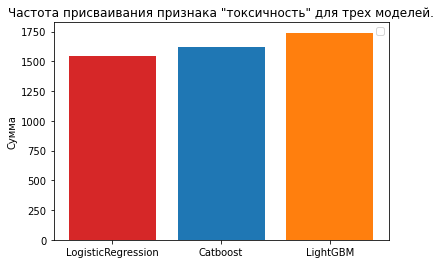

In [130]:
width = 0.35 # the width of the bars: can also be len(x) sequence
fig, ax = plt.subplots()

bar_colors = ['tab:red', 'tab:blue', 'tab:orange']

ax.bar(labels, values, color=bar_colors)

ax.set_ylabel('Сумма')
ax.set_title('Частота предсказания токсичности')
ax.legend()
plt.title('Частота присваивания признака "токсичность" для трех моделей.')
plt.show()

Посмотрим, в каких данных модели чаще всего проявляется признак "токсичность":

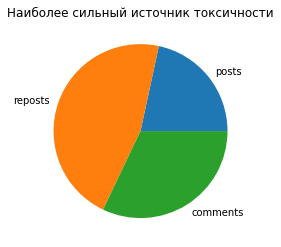

In [131]:
source_values = [df_posts[['toxic_log', 'toxic_cat', 'toxic_lgbm']].sum(axis=0).sum(),
                df_reposts[['toxic_log', 'toxic_cat', 'toxic_lgbm']].sum(axis=0).sum(),
                df_comments[['toxic_log', 'toxic_cat', 'toxic_lgbm']].sum(axis=0).sum()]

source_labels = ['posts', 'reposts', 'comments']

plt.pie(source_values, labels = source_labels)
plt.title('Наиболее сильный источник токсичности')
plt.show()

Проанализируем, какие посты, репосты и комментарии все три модели определили, как токсичные, и составим облако слов:

In [132]:
toxic_posts = df_posts[((df_posts['toxic_log']==1)&(df_posts['toxic_cat']==1)&(df_posts['toxic_lgbm']==1))]
toxic_reposts = df_reposts[((df_reposts['toxic_log']==1)&(df_reposts['toxic_cat']==1)\
                            &(df_reposts['toxic_lgbm']==1))]
toxic_comments = df_comments[((df_comments['toxic_log']==1)&(df_comments['toxic_cat']==1)&\
                              (df_comments['toxic_lgbm']==1))]

In [133]:
def to_str(data, text_col):
    toxic_str = ''
    for index, row in data.iterrows(): 
        toxic_str = toxic_str + str(row[text_col]) + ' '
    
    return toxic_str

In [165]:
toxic_data_text = to_str(toxic_posts, 'post')+to_str(toxic_reposts, 'repost')+to_str(toxic_comments, 'comment')

In [166]:
text_tokens = word_tokenize(toxic_data_text)
text = nltk.Text(text_tokens)
fdist = FreqDist(text)
text_raw = " ".join(fdist)

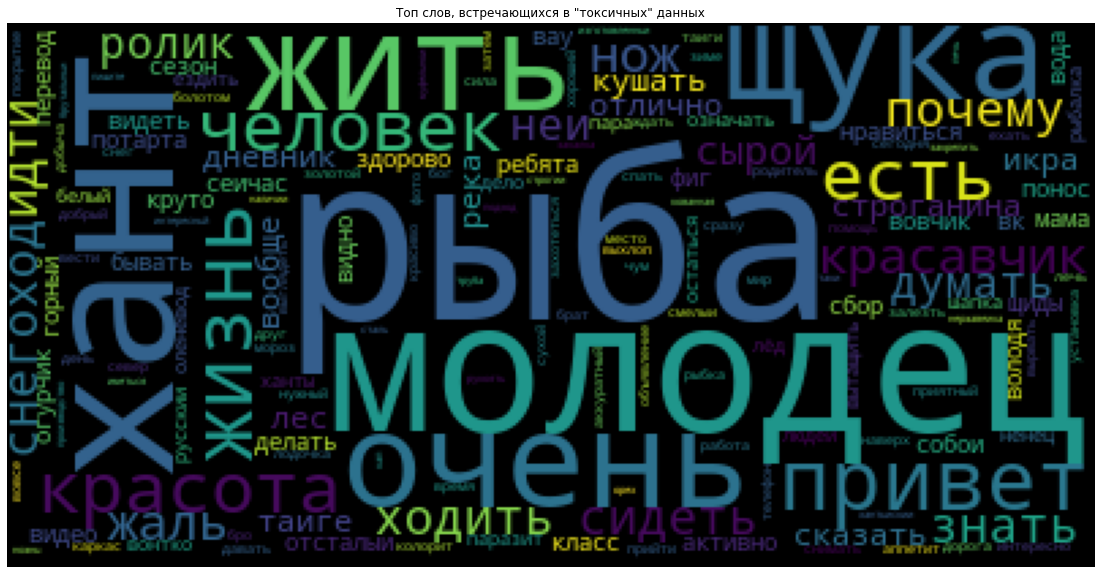

In [167]:
wordcloud = WordCloud().generate(text_raw)
# Визуализация 
plt.figure(figsize=(20,10))
plt.imshow(wordcloud)
plt.title('Топ слов, встречающихся в "токсичных" данных')
plt.axis("off")
plt.show()

Посмотрим на сами данные, которые модели классифицируют, как "токсичные":

In [152]:
stock_files = sorted(glob('C:/Users/Анастасия/programming python/proj_tonality_analysis/Посты_со_стены_сообщества_ханты/*.xlsx'))
df_orig = pd.concat((pd.read_excel(file) for file in stock_files))

In [153]:
toxic_posts_ind = toxic_posts.index

In [155]:
for ind in np.random.choice(toxic_posts_ind, 3):
    print(df_orig.loc[ind, 'text'].values)

[nan nan
 'Няврэм порайн ун хоятат кеман рупитас  Ӆорвош районан Овкурт лепан уӆты Хорьер курта ёхтыӆытэман, иса ащикем нумаӆмаӆэм. Хоты муң ай порайн ӆув хощайӆ ёхтыӆысув. Курта ёхаттэван нови тушаң ащикем трубка уңаӆан катаӆман ещаӆ этаӆ, муңев апаӆмаӆӆы, мотемаӆӆы. Щаӆта хошам хотаӆа ӆоңӆув каврам шайн, ям эпӆаң хошикан йинщаӆтаӆаюв. Щи порайн, муң, ай няврэмат нумасысув хун, муй хорпи уӆапса ащикев ус.  Имоӆтыйн ай шай кашң ныйем Любовь Ильинична Рохтымова ащикем уӆапса эӆты потартас: «Ащем Илья Ефимович Лонгортов – ляль порайн рупитам няврэм, Овс муван хув рупитам хоят (Ветеран труда па Ветеран Ямала), Ӆорвош район ям хоят (Почётный гражданин Шурышкарского района). Ащем вуӆы хотан 1927-мет таӆ ун кер тыӆащ ветхощъяңмет хатаӆан сэма питас. Ащеӆ – ханты, Ефим Никитич Лонгортов, антеӆ – охаль, Анна Степановна Новьюхова. Ефим Никитич па Анна Степановна ӆапат няврэм энмаӆсатан, ӆый кутӆаӆан Илья Ефимович няӆмета сэма питас. Энамтаӆ хуват, ӆув ащеӆа вуӆы шавиты нётас. Илья Ефимович нявр

In [156]:
toxic_reposts_ind = toxic_reposts.index

In [157]:
for ind in np.random.choice(toxic_reposts_ind, 5):
    print(df_orig.loc[ind, 'copy_text'].values)

[nan
 'В окружном «Смотре деятельности этнокультурных центров муниципальных образований Югры» вартовчане презентуют этнодеревню.  Напомним, на базе отдыха "Радуга" была сделана реконструкция стойбища ханты. Там представлены: летний и зимний чумы, хлебная печь, инвентарь для охоты и рыбалки, инфраструктура для национальных спортивных забав, полное убранство жилищ. Региональный Смотр призван поддержать самобытное этнокультурное развитие народов Югры.  Параллельно с этим руководитель проекта этнодеревни [id16812769|Екатерина Жукова] готовит и еще одну большую заявку - на Всероссийский конкурс в сфере этногрфического туризма. Вартовчане представят городской опыт в четырех номинациях.  #Нижневартовск #экоэтнодеревня #НатальяРожкина'
 nan nan
 'Мне кажется, что где-то на земле  Есть комната. В ней всё осталось прежним.  Всё тот же зайчик в тонком хрустале,  Тюль на окне с узором очень нежным...    На стенах коврики и скатерть на столе,  Салфеточкой накрыта радиола,  И этот запах, он со мной 

In [158]:
toxic_comments_ind = toxic_comments.index

In [164]:
for ind in np.random.choice(toxic_comments_ind, 5):
    print(df_orig.loc[ind, 'comments'].values)

['Привет. Ножи для себя только делаешь?' nan nan nan nan nan nan nan nan
 nan nan '👍👍👍👍👍' nan
 'Молодец, Екатерина!!!! Ям арийи. 👍👍 | Пумащипа щи хорпи ям мосты ляль ар'
 'Вы бы лучше в группу «Ковчега» написали. Мы всех собак не имеем возможности знать и чипировать.'
 nan]
[nan nan '👏👏👏 | Молодец, дай бог чтоб всё получилось.'
 'С прошедшим с днём рождения  Вера! | Благодарю Вас за поздравление! Я рада быть с Вами! Вы делаете большое дело! Пусть Ваша дорога будет светлой и радостной!'
 nan nan nan nan nan nan nan nan nan nan nan nan]
[nan nan nan 'Отправьте ссылку' nan nan nan nan nan
 'Молодец 👍 👍 👍 👍 👍 | 👍👍шек ям!' nan 'Зачем?????' nan nan nan nan]
['Молодец 👏 | Лезвие притягивает. | Молодец! | 👍 | 🙏👍👍👍 | Отлично, Володя 👌 | А продаёшь ножи?'
 nan
 'Ям нэнгхэт хоща- ям номсат ,ям потрат,ям хорат этлат! Ал омась! | 👍👍👍👍👍 | Красота!'
 nan nan nan 'Здравствуйте! А чья картинка?' nan nan
 '🌸🌸🌸 | 🌷🌷🌷🌷🌷 | С  Днем рождения! Крепкого здоровья и благополучия, творческих успехов во всём. | С 